In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from Bio import Entrez


In [4]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please enter your {var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
_set_env("ANTHROPIC_API_KEY")
_set_env("NCBI_API_KEY")

### TOOLS (for agent)

In [ ]:
### Define Tools

### Tool 1: PubMed Search
Entrez.email = "ekwame001@gmail.com"
# Entrez.api_key = "YOUR_NCBI_API_KEY"  # uncomment for higher rate limits
## eserach software

def search_pubmed(query, retmax=200):
    """Search PubMed and return results."""
    handle = Entrez.esearch(
        db="pubmed",
        term=query,
        retmax=retmax,
        usehistory="y"
    )
    record = Entrez.read(handle)
    handle.close()

    return {
        "count": int(record["Count"]),
        "ids": record["IdList"],
        "webenv": record["WebEnv"],
        "query_key": record["QueryKey"],
    }

### Tool 2: concatenate pubmed queries
def concatenate_pubmed_queries(A1_block, A2_block):
    """
    Concatenate PubMed queries with a base query using a logical operator .
    Args:
        A1_block (str): Terms for Inclusion criteria (concepts) that would concatenated with O_block terms.
        A2_block (str): Terms for Inclusion criteria (methods) that would concatenated with O_block terms.
    Returns:
        str: The combined PubMed query.

    Examples:
    Example 1: User wants to create an advanced pubmed query to retrieve research papers on protein protein interactions. Below are examples of A1 and A2 blocks that would be concatenated with O_block to create the final query.
    -----------
        # A1: INCLUSION CRITERIA - CONCEPTS (protein complexes, interactions)
A1_block = (
    '("nucleoproteins"[MeSH Terms] '
    'OR "protein interaction mapping"[MeSH Terms] '
    'OR (("nucleoprotein"[All Fields] OR "nucleoproteins"[All Fields] '
    'OR "multiprotein"[All Fields] OR "multiproteins"[All Fields] '
    'OR "proteins"[MeSH Terms] OR "protein"[All Fields] '
    'OR "proteins"[All Fields] OR "enzyme"[All Fields]) '
    'AND ("interact"[All Fields] OR "interacted"[All Fields] '
    'OR "interacting"[All Fields] OR "interaction"[All Fields] '
    'OR "interactions"[All Fields] OR "interactivity"[All Fields] '
    'OR "interacts"[All Fields])) '
    'OR "protein interaction"[All Fields] '
    'OR "protein interactions"[All Fields] '
    'OR "interacting protein"[All Fields] '
    'OR "interacting proteins"[All Fields] '
    'OR "multiprotein complexes"[MeSH Terms] '
    'OR (("nucleoprotein"[All Fields] OR "nucleoproteins"[All Fields] '
    'OR "multiprotein"[All Fields] OR "multiproteins"[All Fields] '
    'OR "proteins"[MeSH Terms] OR "protein"[All Fields] '
    'OR "proteins"[All Fields] OR "enzyme"[All Fields]) '
    'AND ("complex"[All Fields] OR "complexes"[All Fields] '
    'OR "heteromer"[All Fields] OR "heteromers"[All Fields] '
    'OR "homomer"[All Fields] OR "homomers"[All Fields] '
    'OR "heteromeric"[All Fields] OR "homomeric"[All Fields] '
    'OR "subunit"[All Fields] OR "subunits"[All Fields])) '
    'OR "protein complex"[All Fields] '
    'OR "protein complexes"[All Fields] '
    'OR ("protein"[All Fields] '
    'AND ("RNA"[All Fields] OR "DNA"[All Fields] '
    'OR "ribonucleic"[All Fields] OR "deoxyribonucleic"[All Fields]) '
    'AND ("interaction"[All Fields] OR "interactions"[All Fields])))'
)

# A2: INCLUSION CRITERIA - METHODS (experimental techniques we want)
A2_block = (
    '("Immunoprecipitation"[MeSH Terms] '
    'OR "coimmunoprecipitation"[All Fields] '
    'OR ("co"[All Fields] AND "immunoprecipitation"[All Fields]) '
    'OR ("RNA"[All Fields] AND "immunoprecipitation"[All Fields]) '
    'OR "co immunoprecipitation"[All Fields] '
    'OR "coIP"[All Fields] '
    'OR "Chromatography, Affinity"[MeSH Terms] '
    'OR "affinity purification"[All Fields] '
    'OR "affinity isolation"[All Fields] '
    'OR "affinity chromatography"[All Fields] '
    'OR ("affinity"[All Fields] AND ("purification"[All Fields] '
    'OR "isolation"[All Fields] OR "chromatography"[All Fields])) '
    'OR "pulldown"[All Fields] '
    'OR ("pull"[All Fields] AND ("down"[All Fields] OR "downs"[All Fields])) '
    'OR "crystallography, x ray"[MeSH Terms] '
    'OR "Nuclear Magnetic Resonance, Biomolecular"[MeSH Terms] '
    'OR "Cryoelectron Microscopy"[MeSH Terms] '
    'OR "Protein Array Analysis"[MeSH Terms] '
    'OR "electrophoretic mobility shift assay"[MeSH Terms] '
    'OR "Surface Plasmon Resonance"[MeSH Terms])'
)
    """
    # O_block (always constant): Terms to exclude unwanted publication types and non-English articles
    O_block = (
    '("english"[Language] '
    'NOT "meta-analysis"[Publication Type] '
    'NOT "review"[Publication Type] '
    'NOT "retracted publication"[Publication Type] '
    'NOT "retraction of publication"[Publication Type] '
    'NOT "published erratum"[Publication Type] '
    'NOT "controlled clinical trial"[Publication Type] '
    'NOT "clinical study"[Publication Type] '
    'NOT "clinical trial"[Publication Type] '
    'NOT "clinical trial protocol"[Publication Type] '
    'NOT "clinical trial, phase i"[Publication Type] '
    'NOT "clinical trial, phase ii"[Publication Type] '
    'NOT "clinical trial, phase iii"[Publication Type] '
    'NOT "clinical trial, phase iv"[Publication Type] '
    'NOT "clinical trial, veterinary"[Publication Type])'
)
    return f"({O_block} AND ({A1_block} OR {A2_block}))" ## needs the other blocks

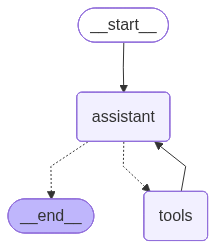

================================ Human Message =================================

I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies and return the pubmed ids
================================== Ai Message ==================================

To create a refined PubMed query for your interest in papers on buffer solutions used in human KRAS protein interaction studies, we will break it down into different components (blocks):

1. **A1_block:** This block will focus on the human KRAS protein and its interactions.
2. **A2_block:** This block will address the specific aspect of buffer solutions.
3. **O_block:** This block will exclude non-English articles and unwanted publication types such as reviews, meta-analyses, clinical trials, etc.

Let's create these blocks:

### A1_block: Concepts
- **KRAS Protein:** We need to capture terms related to human KRAS protein and its interactions.
  
### A2_block: Methods/Approaches
- **Buf

In [ ]:
##### Agent with memory and tool use
######
llm = ChatOpenAI(model="gpt-4o")
tools = [search_pubmed, concatenate_pubmed_queries]
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="""You are a Molecular Biologist and an expert in constructing Advanced Pubmed Queries. 
                        User gives you an idea of what they are interested in and you would give me a refined pubmed query that can be used to retrieve those papers. 
                        Your role is to both help the scientists refine what they want to search for and then construct the actual PubMed Advanced query that captures the papers of interest.
                        Understand what the user is for studying then begin by creating pubmed query terms we call `blocks` that capture different aspects of the user's interest.
                        Specifically, you will always create the following blocks:
                        1. A1_block: A block of terms (for example, MeSH terms) that captures the main concepts of interest called `A1_block`
                        2. A2_block: A block of terms (for example, MeSH terms) that captures the methods/approaches of interest called `A2_block`
                        Note that, There is always a block of terms `O_block` that excludes non-English articles and unwanted publication types such as reviews, meta-analyses, clinical trials etc. that should always be included in the final query.
                        You will then concatenate all the blocks into a final PubMed query using the following logic: `(O_block AND (A1_block OR A2_block))` which you can achieve by using the tool `concatenate_pubmed_queries()`.
                        Always call `concatenate_pubmed_queries()` tool to generate the final query for user and pubmed search.
                        """, 
                        name="system")

# If there there is human feedback it should be options, add this, remove this or that etc...

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work, i don't see why we should define `ToolNode(tools)` if we have already bound the tools to the llm; i guess this explicity uses tools as a node that could we used or ignored by the llm
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

#### FAILURE MEMORY CASE:
pmed_humanMsg= "I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies and return the pubmed ids"
messages = [HumanMessage(content=pmed_humanMsg)]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()



#### SUCEESSFUL MEMORY CASE:

### ADD MEMORY

i am intersted in protocols a,b,c
i am nit interest in d,

Niki pls give me 2 examples
a. affinity purification, coimmunoprecipation, co-ip Mass spectrometry, x-ray crystalography, cryo-em, electrophrofic mobility shift assays (emsa), protein microarrays,
b. chromatin immunoprecipitaiton, photo-activatable (par-clip), footprinting,   


1. agent takes list of interested in (2 or more ideal)
2. agent takes list of protocols not intersted in
--- then create creaste synonymes, analogous protocols, propose more protocols
--- 

In [11]:
memory = MemorySaver()
react_graph_with_memory = builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id":"1"}}

In [ ]:
pmed_humanMsg= ""
messages = [HumanMessage(content=pmed_humanMsg)]
messages = react_graph_with_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

In [12]:
pmed_humanMsg= "I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies"
messages = [HumanMessage(content=pmed_humanMsg)]
messages = react_graph_with_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies
================================== Ai Message ==================================

To create an effective PubMed query for finding papers related to buffer solutions used in human KRAS protein interaction studies, we should focus on two primary aspects:

1. **Concepts of Interest**: Human KRAS protein and its interactions.
2. **Methods/Approaches of Interest**: Buffer solutions used in these studies.

Let's define the blocks for our query:

### A1_block: Concepts of Interest
We want to capture terms related to the human KRAS protein and protein-protein interactions. This will involve the KRAS protein and interaction mapping concepts.

### A2_block: Methods/Approaches of Interest
We will focus on terms related to buffer solutions used in biochemical studies.

Now, I will create the query blocks

In [13]:
messages = [HumanMessage(content="the `A_block` for pubmed terms you returned seems very narrow and might miss relevant papers. Can you suggest additional terms to include in the `A_block` to make it more comprehensive for protein interaction studies?")]
messages = react_graph_with_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies
================================== Ai Message ==================================

To create an effective PubMed query for finding papers related to buffer solutions used in human KRAS protein interaction studies, we should focus on two primary aspects:

1. **Concepts of Interest**: Human KRAS protein and its interactions.
2. **Methods/Approaches of Interest**: Buffer solutions used in these studies.

Let's define the blocks for our query:

### A1_block: Concepts of Interest
We want to capture terms related to the human KRAS protein and protein-protein interactions. This will involve the KRAS protein and interaction mapping concepts.

### A2_block: Methods/Approaches of Interest
We will focus on terms related to buffer solutions used in biochemical studies.

Now, I will create the query blocks